In [2]:
### imports
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [3]:
### rbf kernel
class RBFKernel:
    """radial basis (gaussian) kernel"""
    def __init__(self, sigma=1.0):
        self.sigma = sigma

    def eval(self, x, y):
        dist = torch.sum((x-y)**2)
        return torch.exp(- dist / (2 * self.sigma**2))
    
rbf_kernel = RBFKernel(sigma=1.0)

In [4]:
x = torch.tensor([1,0,2], requires_grad=True, dtype=torch.float32)
y = torch.tensor([3,-1,2], requires_grad=True, dtype=torch.float32)
z = rbf_kernel.eval(x,y)

z.backward()
x.grad

tensor([ 0.1642, -0.0821, -0.0000])

**stein operator**

Let $p(x)$ be a smooth density supported on $\mathcal{X}\subset\mathbb{R}^n$ and $\phi(x)=[\phi_1(x),...,\phi_n(x)]^T$ a smooth function $\mathcal{X}\rightarrow\mathbb{R^n}$. We let the Stein operator be given by the functional operator

$$ \mathcal{A}_p\phi(x) = \phi(x)\nabla_x\log{p(x)}^T + \nabla_x\phi(x) $$

Taking the trace of this operator we get a scalar quantity, known as the Langevin-Stein operator.

In [5]:
def langevin_stein(p, phi, x):
    """
    implementation of the Langevin-Stein operator, which is an operator
    variational objective useful for SVGD.
    """
    # attractive term
    x_a = x.detach().requires_grad_()
    log_prob = torch.log(p(x_a))
    log_prob.backward()
    a_term = torch.dot(phi(x_a), x_a.grad)
    
    # repulsive term
    x_r = x.detach().requires_grad_()
    phi_x = phi(x_r)
    phi_x.backward(torch.ones_like(x_r))
    r_term = torch.sum(x_r.grad)
    
    return a_term + r_term

def p(x):
    return torch.exp(x)

def phi(x):
    return x**3

x = torch.tensor([2.0], requires_grad=True)
langevin_stein(p, phi, x)

tensor(20., grad_fn=<AddBackward0>)

Stein's identity states that for arbitrary $\phi$ we should have $\mathbb{E}_{x\sim p}[\operatorname{trace}{(\mathcal{A}_p\phi(x))}] = 0$. Here the term inside of the expectation is given by the Langevin-Stein operator.

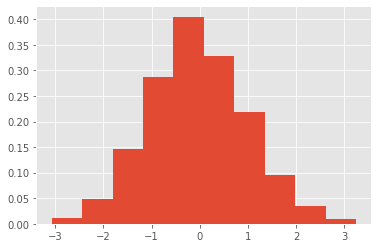

In [6]:
def p(x):
    """
    torch tensor version of N(0,1) gaussian
    """
    return torch.exp(torch.distributions.Normal(0,1).log_prob(x))
    
num_samples = 1000
s = torch.distributions.Normal(0,1).sample((num_samples,))

plot_s = s.detach().numpy()
plt.hist(plot_s, density=True)
plt.show()

In [30]:
from tqdm import tqdm

def ls_expectation(num_samples):
    x = torch.distributions.Normal(0,1).sample((num_samples,))
    ls_vals = torch.zeros(x.shape)
    for i in range(len(x)):
        ls_vals[i] = langevin_stein(p, phi, x[i].view(-1))
    
    return torch.mean(ls_vals)

lss = []
for i in tqdm(range(1, 100)):
    num_samples = 10 * i
    ls = ls_expectation(num_samples).item()
    lss.append(ls)
    
plt.plot(lss)
plt.show()

ModuleNotFoundError: No module named 'tqdm'